# Pull data from BaseSpace CLI

```bash
# Authenticate BaseSpace account in terminal
bs auth

# Obtain the project ID through CLI
bs list projects

# Downloading EXP-01244_BM_on_Chip_2024-10-29T17_49_46_d10a765
bs download project -i 436430464 -o "/home/jupyter/TissDiss/EXP-01244/" --extension fastq.gz 

# Downloading ICA Workflows 2024/10
bs download project -i 434099778 -o "/home/jupyter/TissDiss/EXP-01244/" --extension fastq.gz
```

# Organize workspace

```bash
zip -r /home/jupyter/TissDiss/EXP-01244/EXP-01244_fastqs.zip /home/jupyter/TissDiss/EXP-01244/EXP-01244_fastqs

rm -r /home/jupyter/TissDiss/EXP-01244/EXP-01244_fastqs
```

# Cellranger command

```bash
cr multi --id="EXP-01244" --csv=/home/jupyter/TissDiss/EXP-01244/EXP-01244_config.csv
```

# Creating and starting venv

```bash
source /home/workspace/TissDiss/tissdiss_py_env.sh
```

# Initial setup

In [31]:
import sys
sys.path.insert(0, '/home/workspace/TissDiss')

from tissdiss_py_util import *

hdir = '/home/workspace/'
wdir = hdir + "/TissDiss/EXP-01244"
pltdir = wdir + "/EXP-01244_plots/"
srldir = wdir + "/EXP-01244_serial_obj/"
degdir = wdir + "/EXP_01244_DEGs"

raw_adata = sc.read_h5ad(srldir + 'raw_adata.h5ad')
adata = sc.read_h5ad(srldir + 'processed_adata.h5ad')
adata = adata[adata.obs['harmony'] == 'no harmony']

# processed_adatas_ls = load(srldir + 'processed_adatas.joblib')
# adata = sc.read_h5ad(srldir + 'raw_adata.h5ad')
# batched_adata = sc.read_h5ad(srldir + 'batched_adata.h5ad')
# processed_ds_adata = sc.read_h5ad(srldir + 'processed_ds_adata.h5ad')
# hm_adata = sc.read_h5ad(srldir + 'harmony_test_adata.h5ad')

/home/workspace/TissDiss/tissdiss_py_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Processing Data

## Ingesting h5's

In [ ]:
EXP01244_cr_outs_path = os.path.join(hdir, "TissDiss/EXP-01244/EXP-01244_cr_outs")

adata = ingest_mplex_gex_h5_list(EXP01244_cr_outs_path)

adata.write(srldir + 'raw_adata.h5ad', compression='gzip')

## Processing adatas

In [ ]:
adata = sc.read_h5ad(srldir + 'raw_adata.h5ad')

sample_dict = {
    'week2': "OR07965-01",
    'week3': "OR07965-02",
    'week4': "OR00001",
    'bm': "BMC07965-007",
    'msc': "CELL00911"
}

processed_adatas_ls = {
    name: process_adata(adata[adata.obs['base_sample'] == sample].copy())
    for name, sample in sample_dict.items()
}

dump(processed_adatas_ls, srldir + 'processed_adata_ls.joblib', compress=3)

In [ ]:
batched_adata = process_adata(adata.copy())

batched_adata.write(srldir + 'batched_adata.h5ad', compression='gzip')

## Downsampling

### Downsampling each sampling in raw adata and combining

In [ ]:
samples = adata.obs['base_sample'].values.unique().tolist()

ds_adata = {}

for sample in samples:
    if sample == 'OR07965-02':
        mask = adata.obs['base_sample'] == sample
        ds_adata[sample] = adata[mask]
        continue

    mask = adata.obs['base_sample'] == sample
    downsampled = sc.pp.subsample(
        adata[mask].copy(),
        n_obs = sum(adata.obs['base_sample'] == 'BMC07965-007'),
        random_state = 0,
        copy = True
    )

    ds_adata[sample] = downsampled

ds_adata = ad.concat(ds_adata, label = "base_sample", join = 'outer', merge = 'same')

processed_ds_adata = process_adata(ds_adata.copy())

processed_ds_adata.write(srldir + 'processed_ds_adata.h5ad', compression='gzip')

### Downsampling each sample and processing seperately

In [ ]:
sample_dict = {
    'week2': "OR07965-01",
    'week3': "OR07965-02",
    'week4': "OR00001",
    'bm': "BMC07965-007",
    'msc': "CELL00911"
}

bm_downsampled_adatas = {
    name: (
        process_adata(adata[adata.obs['base_sample'] == sample].copy())
        if sample == "OR07965-02"
        else process_adata(
                sc.pp.subsample(
                    adata[adata.obs['base_sample'] == sample].copy(),
                    n_obs = sum(adata.obs['base_sample'] == 'BMC07965-007'),
                    random_state = 0,
                    copy = True
                )
            )
    )
    
    for name, sample in sample_dict.items()
}

dump(bm_ds_adatas, srldir + 'bm_downsampled_adata_ls.joblib', compress=3)

## Finding optimal cluster resolution

### Optimal cluster resolution for bone marrow

In [ ]:
bm_adata = processed_ds_adata[processed_ds_adata.obs['sample_type'] == 'bm']

range = np.round(np.arange(0.5, 3.0, 0.1), 1)

for res in range:
    sc.tl.leiden(
        bm_adata, 
        flavor="igraph",
        key_added=f"leiden_{str(res).replace('.', '_')}",
        n_iterations=2,
        resolution=res
    )

In [ ]:
fig = clustree(
    bm_adata,
    [f"leiden_{str(res).replace('.', '_')}" for res in range],
    score_clustering="calinski_harabasz",
    score_basis="pca"
)

fig.set_size_inches(15, 20)
fig.set_dpi(100)

# Plotting doublets

In [ ]:
layout = [
    ['week2', 'bm'],
    ['week3', 'msc'],
    ['week4', '.']
]

fig, axd = plt.subplot_mosaic(layout, figsize=(12, 15), gridspec_kw={'hspace': 0.3})

# Create violin plots and add counts
for name, adata in processed_adatas.items():
    false_count = sum(adata.obs['Predicted_Doublet'] == False)
    true_count = sum(adata.obs['Predicted_Doublet'] == True)

    adata.obs['Predicted_Doublet'] = adata.obs['Predicted_Doublet'].astype('category')
    
    if name in axd:
        sc.pl.violin(
            adata,
            "n_genes_by_counts",
            groupby="Predicted_Doublet",
            jitter=0.4,
            multi_panel=True,
            show=False,
            ax=axd[name]
        )
        axd[name].set_title(f'{name} (n={false_count + true_count})')
        
        # Calculate y position slightly lower than the maximum
        y_max = axd[name].get_ylim()[1]
        y_offset = (axd[name].get_ylim()[1] - axd[name].get_ylim()[0]) * 0.02  # 2% of y-axis range
        
        # Add text for False category
        axd[name].text(-0.2, y_max - y_offset, 
                      f'n={false_count}',
                      ha='center', va='top')
        
        # Add text for True category (if exists)
        if true_count > 0:
            axd[name].text(0.8, y_max - y_offset, 
                          f'n={true_count}',
                          ha='center', va='top')

plt.savefig(pltdir + "doublet_plots.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# Plotting Ig and MT genes

## Batched MT violin plots

In [ ]:
layout = [
    ['week2', 'bm'],
    ['week3', 'msc'],
    ['week4', '.']
]

fig, axd = plt.subplot_mosaic(layout, figsize=(12, 15), gridspec_kw={'hspace': 0.3})

# Create violin plots and add counts
for name, adata in processed_adatas.items():
    false_count = sum(adata.obs['Predicted_Doublet'] == False)
    true_count = sum(adata.obs['Predicted_Doublet'] == True)

    adata.obs['Predicted_Doublet'] = adata.obs['Predicted_Doublet'].astype('category')
    
    if name in axd:
        sc.pl.violin(
            adata,
            "n_genes_by_counts",
            groupby="Predicted_Doublet",
            jitter=0.4,
            multi_panel=True,
            show=False,
            ax=axd[name]
        )
        axd[name].set_title(f'{name} (n={false_count + true_count})')
        
        # Calculate y position slightly lower than the maximum
        y_max = axd[name].get_ylim()[1]
        y_offset = (axd[name].get_ylim()[1] - axd[name].get_ylim()[0]) * 0.02  # 2% of y-axis range
        
        # Add text for False category
        axd[name].text(-0.2, y_max - y_offset, 
                      f'n={false_count}',
                      ha='center', va='top')
        
        # Add text for True category (if exists)
        if true_count > 0:
            axd[name].text(0.8, y_max - y_offset, 
                          f'n={true_count}',
                          ha='center', va='top')

plt.savefig(pltdir + "doublet_plots.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()

## Total Ig violin plots

In [ ]:
layout = [
    ['week2', 'bm'],
    ['week3', 'msc'],
    ['week4', '.']
]

# Create figure with extra space for colorbars
fig, axd = plt.subplot_mosaic(layout, figsize=(12, 15), gridspec_kw={'hspace': 0.3})

# Create scatter plots
for name, adata in processed_adatas.items():
    if name in axd:
        adata.obs['has_ig'] = adata.obs['total_counts_ig'] > 0
        adata.obs['has_ig'] = adata.obs['has_ig'].astype('category')
        
        n_cells = len(adata.obs)
        with_ig_count = sum(adata.obs['has_ig'] == True)
        without_ig_count = sum(adata.obs['has_ig'] == False)
        
        sc.pl.violin(
            adata,
            "total_counts_ig",
            # groupby="has_ig",
            jitter=0.4,
            log=True,
            show=False,
            ax=axd[name]
        )

        axd[name].set_title(f'{name} (n={n_cells})')

        axd[name].text(-0.35, axd[name].get_ylim()[1] * 0.8, 
                      f'n (w/ Ig)={with_ig_count}',
                      ha='left', va='top')

        axd[name].text(-0.35, axd[name].get_ylim()[1] * 0.5, 
                      f'n (w/o Ig)={without_ig_count}',
                      ha='left', va='top')

plt.savefig(pltdir + 'ig_violin_plots.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Total Ig scatter plots

In [ ]:
layout = [
    ['week2', 'bm'],
    ['week3', 'msc'],
    ['week4', '.']
]

# Create figure with extra space for colorbars
fig, axd = plt.subplot_mosaic(layout, figsize=(12, 15), gridspec_kw={'hspace': 0.3})

# Create scatter plots
for name, adata in processed_adatas.items():
    if name in axd:
        n_cells = len(adata.obs)
        n_cells_ig = sum(adata.obs['total_counts_ig'] > 0)
        
        sc.pl.scatter(
            adata, 
            "total_counts", 
            "n_genes_by_counts", 
            color="pct_counts_ig",
            show=False,
            title=name,
            ax=axd[name]
        )
        
        axd[name].set_title(f'{name} (n={n_cells})')
        
        axd[name].text(0.55, 0.05,
                      f'n cells w/ ig={n_cells_ig}',
                      transform=axd[name].transAxes,
                      ha='left',
                      va='bottom')

plt.savefig(pltdir + 'ig_scatter_plots.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Total Ig matrix plots

In [ ]:
layout = [
    ['week2'],
    ['week3'],
    ['week4'],
    ['bm'],
    ['msc']
]

fig, axd = plt.subplot_mosaic(layout, 
                            figsize=(12, 20), 
                            gridspec_kw={'hspace': 0.4})

for name, adata in processed_adatas.items():
    if name in axd:
        ig_genes = adata.var_names[adata.var['ig']]
        
        sc.pl.matrixplot(
            adata,
            ig_genes,
            groupby='leiden',
            ax=axd[name],  # Pass the specific axis
            show=False,    # Prevent automatic showing
            var_group_positions=[(23,24)],
            var_group_labels=['IGHA1 & IGHG1'],
            var_group_rotation=0
        )

        axd[name].set_title(name, x=0.4, y=0.86, pad=15)

plt.savefig(pltdir + 'ig_matrix_plots.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Melinda's PAGA DEG to csv and trajectory plots

In [ ]:
sc.pl.paga(processed_adatas['week2'], color=["leiden"])
sc.pl.umap(processed_adatas['week2'], color = "leiden", size = 1.5)

In [ ]:
for sample_name, adata in processed_adatas.items():
    
    # Extract the ranking information
    ranking = adata.uns['rank_genes_groups']
    gene_names = ranking['names']
    gene_scores = ranking['scores']
    gene_pvals_adj = ranking['pvals_adj']
    clusters = gene_names.dtype.names
    
    # Create a DataFrame to store all differentially expressed genes with pvals_adj < 0.05
    de_genes = []
    for cluster in clusters:
        names = gene_names[cluster]
        scores = gene_scores[cluster]
        pvals_adj = gene_pvals_adj[cluster]
        for name, score, pval_adj in zip(names, scores, pvals_adj):
            if pval_adj < 0.05:
                de_genes.append((cluster, name, score, pval_adj))
    
    df_de_genes = pd.DataFrame(de_genes, columns=['Cluster', 'Gene', 'Score', 'Adjusted p-value'])
    df_de_genes.to_csv(f'EXP_01244_DEGs/{sample_name}_DEG_in_clusters.csv', index=False)

    # Print significant genes for each cluster
    print("Significant genes for each cluster:")
    for cluster in clusters:
        print(f"Cluster {cluster}:")
        cluster_genes = df_de_genes[df_de_genes['Cluster'] == cluster]
        # print(cluster_genes[['Gene', 'Score', 'Adjusted p-value']])
    
    # Visualize the PAGA graph with marker genes
    fig, ax = plt.subplots(figsize=(30, 24))
    sc.pl.paga(adata, threshold=0.01, node_size_scale=20, fontsize=16, ax=ax, show=False)
    
    # Annotate the PAGA graph with marker genes
    for cluster in clusters:
        cluster_genes = df_de_genes[df_de_genes['Cluster'] == cluster]['Gene'].unique()
        cluster_genes_str = ', '.join(cluster_genes[:3])  # Display only top 3 genes for clarity
        node_pos = adata.uns['paga']['pos'][int(cluster)]
        ax.text(node_pos[0], node_pos[1] + 0.1, cluster_genes_str, fontsize=16, ha='center')  # Offset the text label
    
    # Save and show the annotated PAGA graph
    plt.tight_layout()
    plt.savefig('paga_graph_with_marker_genes.png', dpi=300)
    plt.show()

# Plotting PCA variance ratio

In [ ]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [ ]:
sc.pl.pca(
    processed_adatas['week2'],
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

# Plotting DEG's

In [ ]:
layout = [
    ['week2'],
    ['week3'],
    ['week4'],
    ['bm'],
    ['msc']
]

fig, axd = plt.subplot_mosaic(layout, figsize=(20, 35), gridspec_kw={'hspace': 0.15})

for name, adata in processed_adatas.items():
    if name in axd:
        sc.pl.rank_genes_groups_dotplot(
            adata,
            groupby="leiden",
            standard_scale="var",
            n_genes=5,
            ax=axd[name],
            show=False
        )
        
        axd[name].set_title(name, x=0.4, y=0.86, pad=15)

plt.savefig(pltdir + 'DEG_dotplots.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Plotting HSC/eythroblast markers

## HSC/eythroblast marker matrix plots

In [ ]:
hsc_markers = ['SLC4A1', 'AHSP', 'ALAS2', 'HEMGN', 'SNCA', 'GYPA', 'MKI67', 'CENPF', 'CDK1']

layout = [
    ['week2'],
    ['week3'],
    ['week4'],
    ['bm'],
    ['msc']
]

fig, axd = plt.subplot_mosaic(layout, 
                            figsize=(12, 20), 
                            gridspec_kw={'hspace': 0.4})

for name, adata in processed_adatas.items():
    if name in axd:
        sc.pl.matrixplot(
            adata,
            hsc_markers,
            groupby='leiden',
            ax=axd[name],  # Pass the specific axis
            show=False,    # Prevent automatic showing
        )

        axd[name].set_title(name, x=0.3, y=0.86, pad=15)

plt.savefig(pltdir + 'hsc_matrix_plots.pdf', format='pdf', bbox_inches='tight')
plt.show()

## HSC/eythroblast marker umap plots

In [ ]:
hsc_markers = ['SLC4A1', 'AHSP', 'ALAS2', 'HEMGN', 'SNCA', 'GYPA', 'MKI67', 'CENPF', 'CDK1']

hsc_markers_umap = {
    name: sc.pl.umap(
        adata,
        color=[*hsc_markers, "leiden"],
        color_map='magma',
        legend_loc="on data",
        frameon=False,
        ncols=3,
    )
    for name, adata in processed_adatas.items()
}

# Batched downsampled data analysis

## UMAP plots

### Sample Type UMAP (Not Downsampled)

In [ ]:
fig, ax = plt.subplots()

sc.pl.umap(batched_adata, color = "sample_type", size = 1.5, ax=ax, show=False)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

sample_dict = {
    'week2': "OR07965-01",
    'week3': "OR07965-02",
    'week4': "OR00001",
    'bm': "BMC07965-007",
    'msc': "CELL00911"
}

cells = {
    type: sum(batched_adata.obs['base_sample'] == sample)
    for type, sample in sample_dict.items()
}

text = '\n'.join(
    f'{type} (n={count:,})'
    for type, count in cells.items()
)

plt.text(
    x_max * 0.54,
    y_max * 0.6,
    text
)

plt.title('Not Downsampled UMAP')

plt.savefig(pltdir + 'not_downsampled_batched_umap.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Sample Type UMAP (Downsampled)

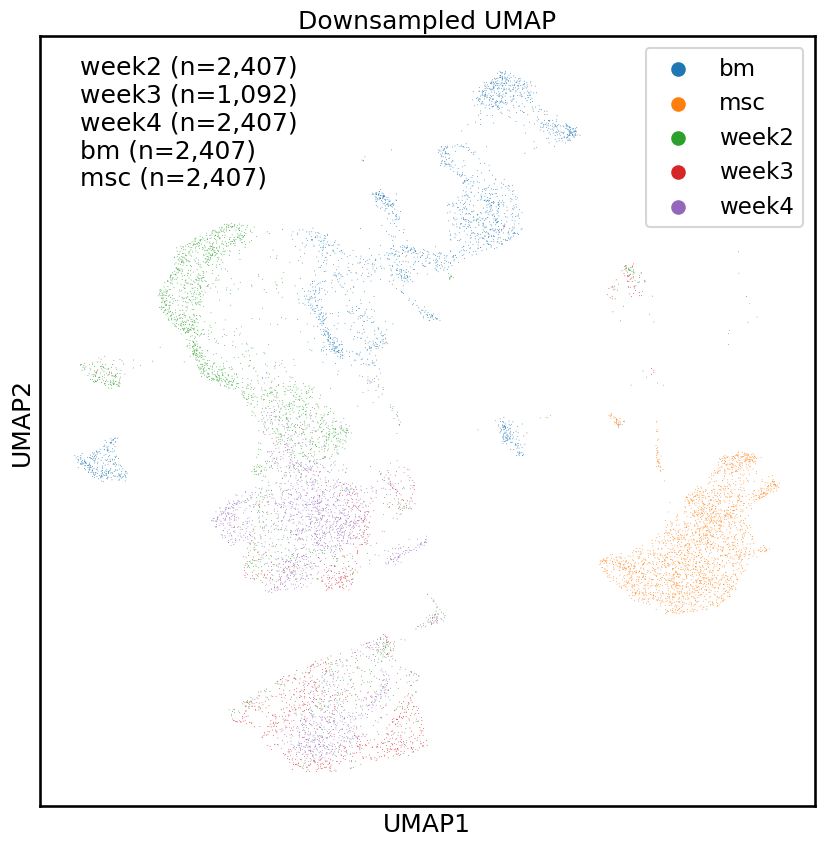

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

sc.pl.umap(adata, color="sample_type", size=1.5, ax=ax, show=False, legend_loc='best')

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

sample_dict = {
    'week2': "OR07965-01",
    'week3': "OR07965-02",
    'week4': "OR00001",
    'bm': "BMC07965-007",
    'msc': "CELL00911"
}

cells = {
    sample_type: sum(adata.obs['base_sample'] == sample_id)
    for sample_type, sample_id in sample_dict.items()
}

text = '\n'.join(
    f'{type} (n={count:,})'
    for type, count in cells.items()
)

plt.text(
    x_max * -0.65,
    y_max * 0.7,
    text
)

plt.title('Downsampled UMAP')

plt.savefig(pltdir + 'downsampled_batched_sample_umap.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Cell Type UMAP (Downsampled)

In [42]:
mask = adata.obs['sample_type'] == 'bm'
# list(set(adata[mask].obs['leiden']))

ranking = adata[mask].uns['rank_genes_groups']
ranking.keys()

dict_keys(['logfoldchanges', 'names', 'params', 'pvals', 'pvals_adj', 'scores'])

In [43]:
mask = adata.obs['sample_type'] == 'bm'
ranking = adata[mask].uns['rank_genes_groups']
gene_names = ranking['names']
gene_scores = ranking['scores']
gene_pvals_adj = ranking['pvals_adj']
clusters = gene_names.dtype.names

# de_genes = []
# for cluster in clusters:
#     names = gene_names[cluster]
#     scores = gene_scores[cluster]
#     pvals_adj = gene_pvals_adj[cluster]
#     for name, score, pval_adj in zip(names, scores, pvals_adj):
#         if pval_adj < 0.05:
#             de_genes.append((cluster, name, score, pval_adj))

# df_de_genes = pd.DataFrame(de_genes, columns=['Cluster', 'Gene', 'Score', 'Adjusted p-value'])
# df_de_genes.to_csv(degdir + f'{tissue_type}_DEGs.csv', index=False)

dtype([('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O'), ('7', 'O'), ('8', 'O'), ('9', 'O'), ('10', 'O'), ('11', 'O'), ('12', 'O'), ('13', 'O'), ('14', 'O'), ('15', 'O'), ('16', 'O'), ('17', 'O'), ('18', 'O'), ('19', 'O'), ('20', 'O'), ('21', 'O'), ('22', 'O'), ('23', 'O'), ('24', 'O'), ('25', 'O'), ('26', 'O'), ('27', 'O'), ('28', 'O'), ('29', 'O'), ('30', 'O')])

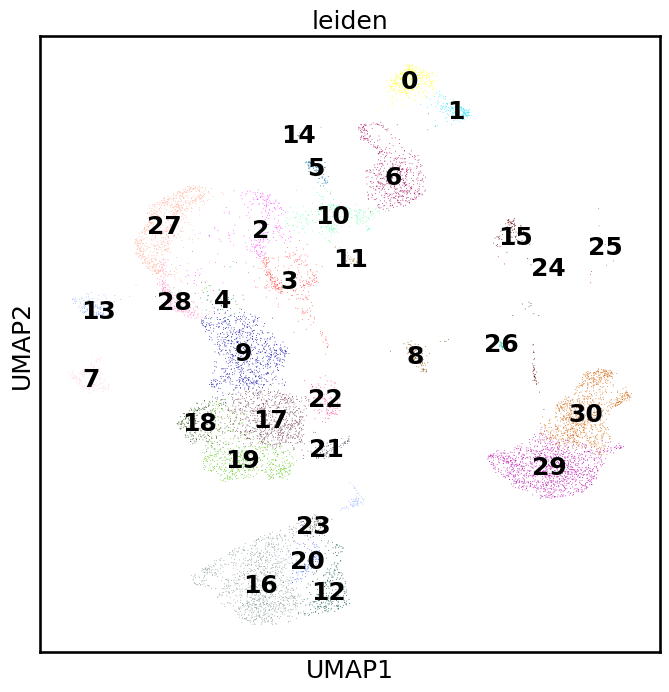

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))

sc.pl.umap(adata, color="leiden", size=1.5, ax=ax, show=False, legend_loc='on data')

plt.savefig(pltdir + 'downsampled_batched_cluster_umap.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Combined Batched UMAP plots

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(26, 8), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

ax = axs.flatten()

ax1 = ax[0]

sc.pl.umap(batched_adata, color = "sample_type", size = 1.5, ax=ax1, show=False, legend_loc='best')

x_min, x_max = ax1.get_xlim()
y_min, y_max = ax1.get_ylim()

sample_dict = {
    'week2': "OR07965-01",
    'week3': "OR07965-02",
    'week4': "OR00001",
    'bm': "BMC07965-007",
    'msc': "CELL00911"
}

cells = {
    type: sum(batched_adata.obs['base_sample'] == sample)
    for type, sample in sample_dict.items()
}

text = '\n'.join(
    f'{type} (n={count:,})'
    for type, count in cells.items()
)

ax1.text(x_max * 0.6, y_max * 0.72, text)

ax1.set_title('Not Downsampled Sample Type UMAP')

ax2 = ax[1]

sc.pl.umap(processed_ds_adata, color="sample_type", size=1.5, ax=ax2, show=False, legend_loc='best')

x_min, x_max = ax2.get_xlim()
y_min, y_max = ax2.get_ylim()

sample_dict = {
    'week2': "OR07965-01",
    'week3': "OR07965-02",
    'week4': "OR00001",
    'bm': "BMC07965-007",
    'msc': "CELL00911"
}

cells = {
    sample_type: sum(processed_ds_adata.obs['base_sample'] == sample_id)
    for sample_type, sample_id in sample_dict.items()
}

text = '\n'.join(
    f'{type} (n={count:,})'
    for type, count in cells.items()
)

ax2.text(x_max * -0.3, y_max * 0.74, text)

ax2.set_title('Downsampled Sample Type UMAP')

ax3 = ax[2]

sc.pl.umap(processed_ds_adata, color="leiden", size=1.5, ax=ax3, show=False, legend_loc='on data')

ax3.set_title('Downsampled Cluster UMAP')

plt.savefig(pltdir + 'combined_batched_umaps.pdf', format='pdf', bbox_inches='tight')
plt.show

In [10]:
adata[adata.obs['sample_type'] == 'bm']

View of AnnData object with n_obs × n_vars = 4814 × 18023
    obs: 'Doublet_Score', 'Predicted_Doublet', 'sample', 'base_sample', 'sample_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ig', 'log1p_total_counts_ig', 'pct_counts_ig', 'harmony', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ig', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'draw_graph', 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'rank_genes_groups', 'umap', 'leiden_colors', 'sample_type_colors'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_umap'
    varm: 'PCs'
  

## DEGs

### DEG Heatmap Plot

In [ ]:
fig, axs = plt.subplots(figsize=(26, 7.4))

ax = axs.flatten()

sc.pl.rank_genes_groups_dotplot(
    processed_ds_adata,
    groupby="leiden",
    standard_scale="var",
    n_genes=5,
    ax=ax,
    show=False
)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

ax.set_title('Downsampled  Cluster DEGs', y=0.92)

plt.savefig(pltdir + 'downsampled_batched_umap.pdf', format='pdf', bbox_inches='tight')
plt.show()

### PAGA DEG CSV

In [ ]:
sample_types = hm_adata.obs['sample_type'].unique()

for type in sample_types:
    mask = hm_adata.obs['sample_type'] == type
    ranking = hm_adata[mask].uns['rank_genes_groups']
    gene_names = ranking['names']
    gene_scores = ranking['scores']
    gene_pvals_adj = ranking['pvals_adj']
    clusters = gene_names.dtype.names
    
    de_genes = []
    for cluster in clusters:
        names = gene_names[cluster]
        scores = gene_scores[cluster]
        pvals_adj = gene_pvals_adj[cluster]
        for name, score, pval_adj in zip(names, scores, pvals_adj):
            if pval_adj < 0.05:
                de_genes.append((cluster, name, score, pval_adj))
    
    df_de_genes = pd.DataFrame(de_genes, columns=['Cluster', 'Gene', 'Score', 'Adjusted p-value'])
    df_de_genes.to_csv(degdir + f'{type}_DEGs.csv', index=False)

In [ ]:
import sys
sys.path.insert(0, '/home/jupyter/TissDiss')

from tissdiss_py_util import *

hdir = '/home/jupyter'
wdir = hdir + "/TissDiss/EXP-01244"
pltdir = wdir + "/EXP-01244_plots/"
srldir = wdir + "/EXP-01244_serial_obj/"
degdir = wdir + "/EXP_01244_DEGs/"

adata = sc.read_h5ad(srldir + 'raw_adata.h5ad')

def functions(adata):
    sc.pp.neighbors(adata)
    sc.tl.draw_graph(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(
        adata, 
        flavor="igraph", 
        n_iterations=2,
        resolution=1.1
    )
    sc.tl.paga(adata, groups='leiden')
    sc.tl.rank_genes_groups(
        adata, 
        groupby="leiden", 
        method="wilcoxon"
    )

    return(adata)

def process_adata(adata):

    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ig"] = adata.var_names.str.contains("^IG")

    adata = adata[:, (adata.var['mt'] == False) & (adata.var['ig'] == False)]

    sc.pp.calculate_qc_metrics(
        adata, 
        qc_vars=["mt", "ig"],
        inplace=True,
        log1p=True
    )

    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(
        adata, 
        n_top_genes=2000, 
        batch_key="sample"
    )
    sc.tl.pca(adata)

    hm_adata = adata.copy()

    X = hm_adata.obsm['X_pca'].astype(np.float64)

    harmony_out = hm.run_harmony(X, hm_adata.obs, 'sample_type')

    hm_adata.obsm['hm_X_pca'] = harmony_out.Z_corr.T

    adatas = {
        'adata': functions(adata),
        'hm_adata': functions(hm_adata)
    }

    adatas['adata'].obs['harmony'] = 'no harmony'
    adatas['hm_adata'].obs['harmony'] = 'harmony'

    full_adata = ad.concat(adatas, join = 'outer', merge = 'same')

    return full_adata

adata = process_adata(adata)

# sample_types = adata.obs['sample_type'].unique()

# for type in sample_types:
#     mask = adata.obs['sample_type'] == type
#     ranking = adata[mask].uns['rank_genes_groups']
#     gene_names = ranking['names']
#     gene_scores = ranking['scores']
#     gene_pvals_adj = ranking['pvals_adj']
#     clusters = gene_names.dtype.names
    
#     de_genes = []
#     for cluster in clusters:
#         names = gene_names[cluster]
#         scores = gene_scores[cluster]
#         pvals_adj = gene_pvals_adj[cluster]
#         for name, score, pval_adj in zip(names, scores, pvals_adj):
#             if pval_adj < 0.05:
#                 de_genes.append((cluster, name, score, pval_adj))
    
#     df_de_genes = pd.DataFrame(de_genes, columns=['Cluster', 'Gene', 'Score', 'Adjusted p-value'])
#     df_de_genes.to_csv(degdir + f'{type}_DEGs.csv', index=False)

In [ ]:
sc.pp.neighbors(adata)
sc.tl.draw_graph(adata)
sc.tl.umap(adata)
sc.tl.leiden(
    adata, 
    flavor="igraph", 
    n_iterations=2,
    resolution=1.1
)
sc.tl.paga(adata, groups='leiden')
sc.tl.rank_genes_groups(
    adata, 
    groupby="leiden", 
    method="wilcoxon"
)

## Trajectory Plots

KeyError: "Could not find 'diffmap' or 'X_diffmap' in .obsm"

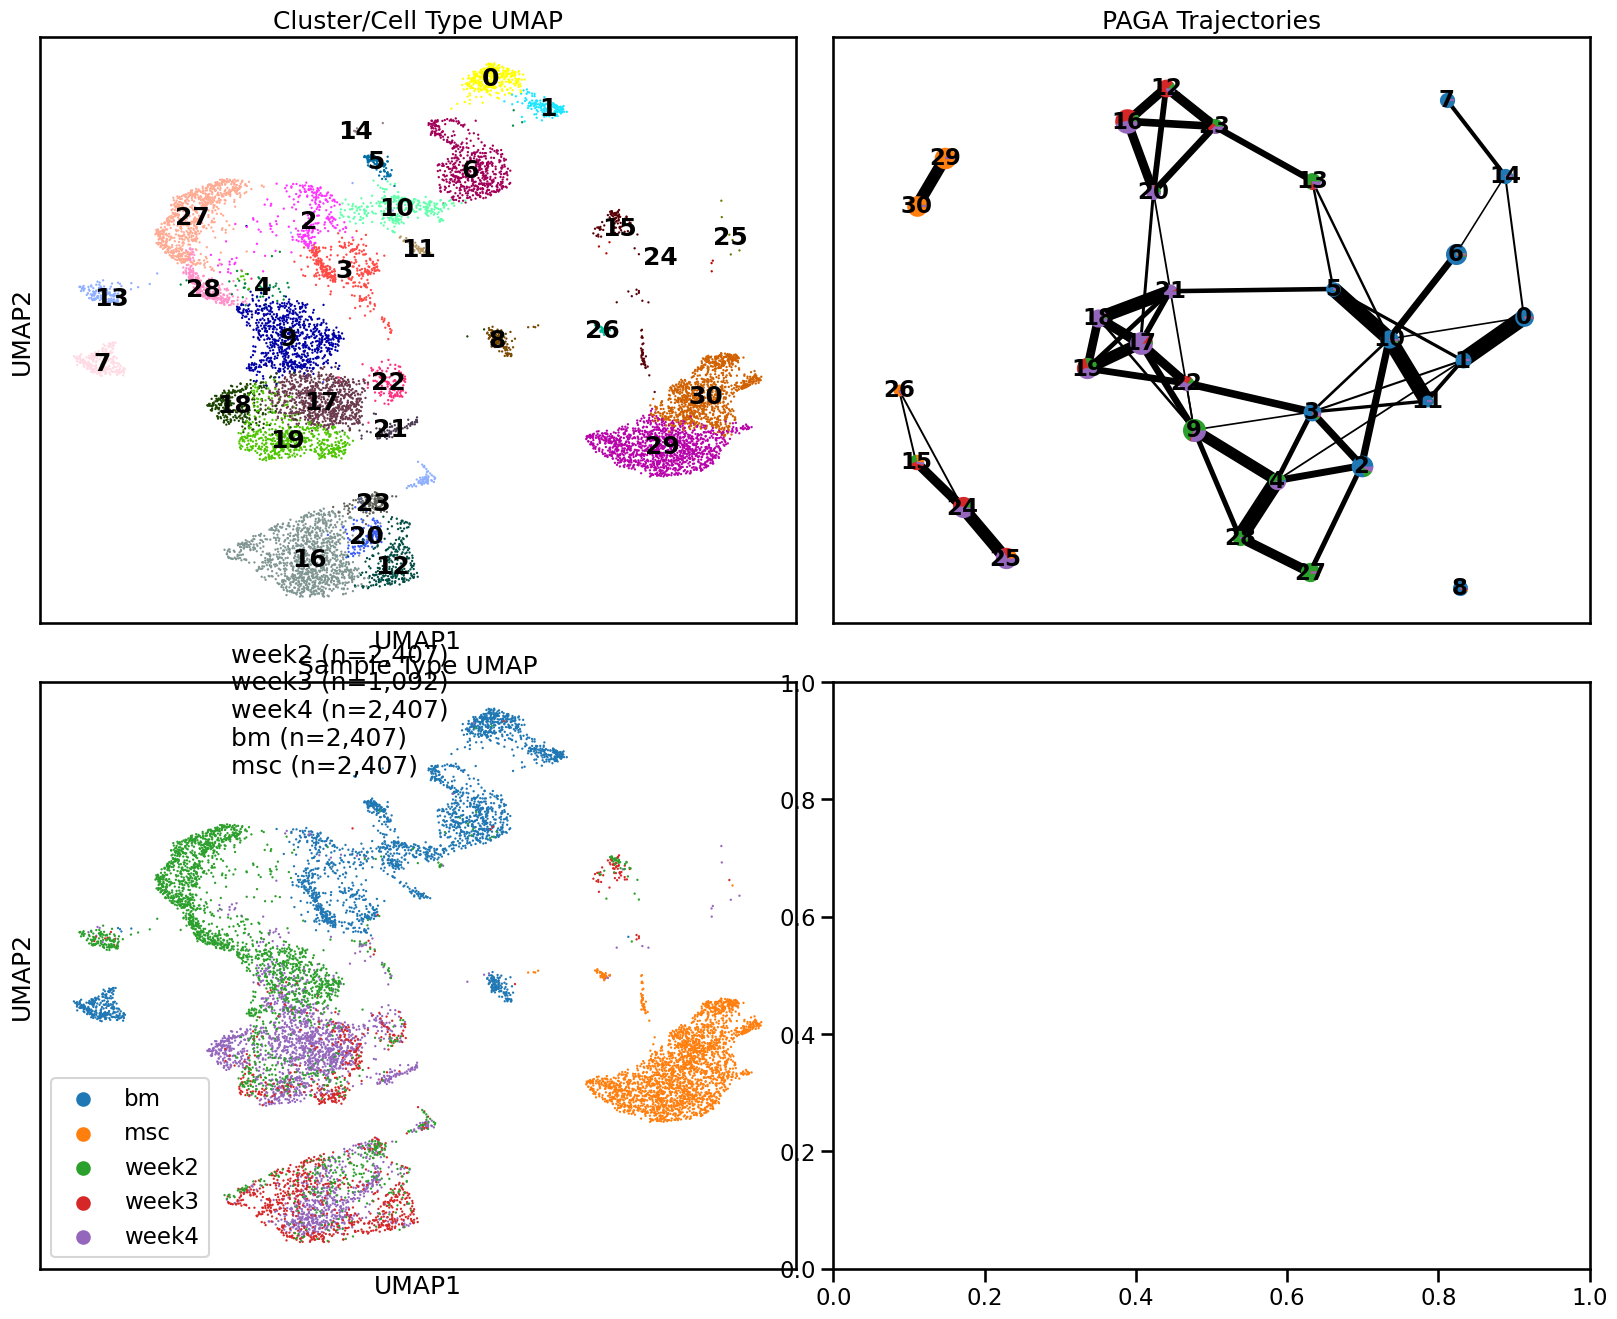

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(20, 16), gridspec_kw={'wspace':0.05, 'hspace':0.1})

ax = ax.flatten()

ax3 = ax[2]
sc.pl.umap(adata, color='sample_type', legend_loc='best', ax=ax3, show=False)

x_min, x_max = ax3.get_xlim()
y_min, y_max = ax3.get_ylim()

sample_dict = {
    'week2': "OR07965-01",
    'week3': "OR07965-02",
    'week4': "OR00001",
    'bm': "BMC07965-007",
    'msc': "CELL00911"
}

cells = {
    sample_type: sum(adata.obs['base_sample'] == sample_id)
    for sample_type, sample_id in sample_dict.items()
}

text = '\n'.join(
    f'{type} (n={count:,})'
    for type, count in cells.items()
)

ax3.text(x_max * -0.3, y_max * 0.76, text)
ax3.set_title('Sample Type UMAP')

ax2 = ax[1]
sc.pl.paga(adata, color=["sample_type"], ax=ax2, show=False, threshold=0.1)
ax2.set_title('PAGA Trajectories')

ax1 = ax[0]
sc.pl.umap(adata, color='leiden', legend_loc='on data', ax=ax1, show=False)
ax1.set_title('Cluster/Cell Type UMAP')

ax4 = ax[3]
sc.pl.diffmap(adata, color='leiden', legend_loc='on data', legend_fontsize=9, ax=ax4, show=False)
ax4.set_title('Cluster/Cell Type Diffusion Map')

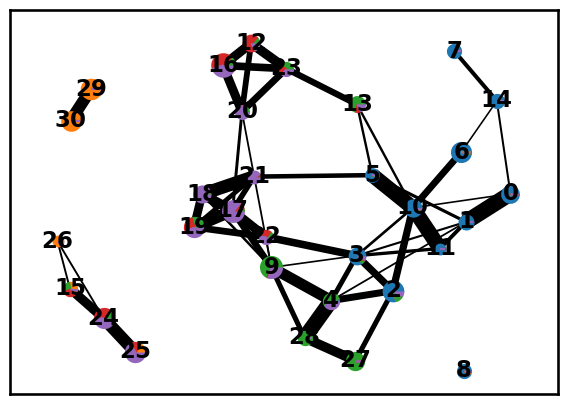

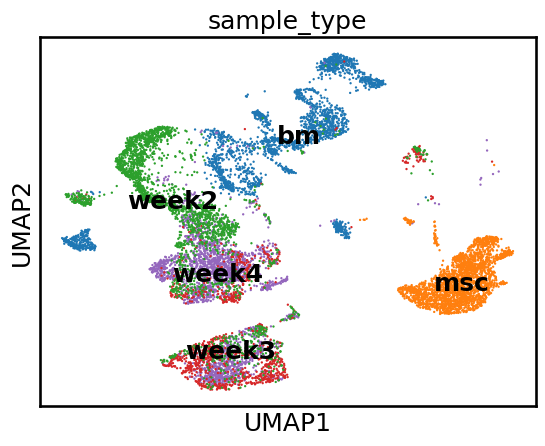

In [76]:
sc.pl.paga(adata, color=["sample_type"], threshold=0.1)
sc.pl.umap(adata, color='sample_type', legend_loc='on data')

In [69]:
help(sc.pl.paga)

Help on function paga in module scanpy.plotting._tools.paga:

paga(adata: 'AnnData', *, threshold: 'float | None' = None, color: 'str | Mapping[str | int, Mapping[Any, float]] | None' = None, layout: '_Layout | None' = None, layout_kwds: 'Mapping[str, Any]' = mappingproxy({}), init_pos: 'np.ndarray | None' = None, root: 'int | str | Sequence[int] | None' = 0, labels: 'str | Sequence[str] | Mapping[str, str] | None' = None, single_component: 'bool' = False, solid_edges: 'str' = 'connectivities', dashed_edges: 'str | None' = None, transitions: 'str | None' = None, fontsize: 'int | None' = None, fontweight: 'str' = 'bold', fontoutline: 'int | None' = None, text_kwds: 'Mapping[str, Any]' = mappingproxy({}), node_size_scale: 'float' = 1.0, node_size_power: 'float' = 0.5, edge_width_scale: 'float' = 1.0, min_edge_width: 'float | None' = None, max_edge_width: 'float | None' = None, arrowsize: 'int' = 30, title: 'str | None' = None, left_margin: 'float' = 0.01, random_state: 'int | None' = 0, 

## Harmony

In [ ]:
import sys
sys.path.insert(0, '/home/jupyter/TissDiss')

from tissdiss_py_util import *

hdir = '/home/jupyter'
wdir = hdir + "/TissDiss/EXP-01244"
pltdir = wdir + "/EXP-01244_plots/"
srldir = wdir + "/EXP-01244_serial_obj/"

adata = sc.read_h5ad(srldir + 'raw_adata.h5ad')

def process_adata(adata):

    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ig"] = adata.var_names.str.contains("^IG")

    adata = adata[:, (adata.var['mt'] == False) & (adata.var['ig'] == False)]

    sc.pp.calculate_qc_metrics(
        adata, 
        qc_vars=["mt", "ig"],
        inplace=True,
        log1p=True
    )

    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(
        adata, 
        n_top_genes=2000, 
        batch_key="sample"
    )
    sc.tl.pca(adata)

    hm_adata = adata.copy()

    X = hm_adata.obsm['X_pca'].astype(np.float64)

    harmony_out = hm.run_harmony(X, hm_adata.obs, 'sample_type')

    hm_adata.obsm['X_pca'] = harmony_out.Z_corr.T

    adatas = {
        'adata': adata,
        'hm_adata': hm_adata
    }

    adatas['adata'].obs['harmony'] = 'no harmony'
    adatas['hm_adata'].obs['harmony'] = 'harmony'

    full_adata = ad.concat(adatas, join = 'outer', merge = 'same')

    sc.pp.neighbors(full_adata)
    sc.tl.draw_graph(full_adata)
    sc.tl.umap(full_adata)
    sc.tl.leiden(
        full_adata, 
        flavor="igraph", 
        n_iterations=2,
        resolution=0.9
    )
    sc.tl.paga(full_adata, groups='leiden')
    sc.tl.rank_genes_groups(
        full_adata, 
        groupby="leiden", 
        method="wilcoxon"
    )

    return full_adata

adata = process_adata(adata)

adata.write(srldir + 'harmony_test_adata.h5ad', compression='gzip')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30, 8))

sc.pl.umap(
    hm_adata,
    color='harmony',
    legend_loc='best',
    ax=ax[0],
    show=False
)

sc.pl.umap(
    hm_adata[hm_adata.obs['harmony'] == 'no harmony'],
    color='sample_type',
    legend_loc='best',
    ax=ax[1],
    show=False
)

sc.pl.umap(
    hm_adata[hm_adata.obs['harmony'] == 'harmony'],
    color='sample_type',
    legend_loc='best',
    ax=ax[2],
    show=False
)

# plt.savefig(pltdir + 'harmony_test_umap.pdf', format='pdf', bbox_inches='tight')

### Local Inverse Simpson Index (LISI) 

In [ ]:
import scib

scib.metrics.lisi.lisi_graph(
    hm_adata,
    batch_key='harmony',
    label_key='harmony',
    type_='full',
    n_cores=60
)

In [ ]:
def calculate_batch_mixing(adata, batch_key='harmony'):
    import scanpy as sc
    import numpy as np
    import pandas as pd
    
    if 'neighbors' not in adata.uns:
        sc.pp.neighbors(adata)
        
    # Get kNN graph
    knn_matrix = adata.obsp['connectivities']
    
    # Get batch labels
    batch_labels = pd.Categorical(adata.obs[batch_key]).codes
    n_batches = len(np.unique(batch_labels))
    
    scores = []
    for i in range(adata.n_obs):
        # Get neighbors
        neighbors = knn_matrix[i].indices
        neighbor_batches = batch_labels[neighbors]
        
        # Calculate batch mixing score
        batch_fractions = np.zeros(n_batches)
        for b in range(n_batches):
            batch_fractions[b] = np.mean(neighbor_batches == b)
            
        # Calculate entropy
        batch_fractions = batch_fractions[batch_fractions > 0]
        score = -np.sum(batch_fractions * np.log(batch_fractions))
        scores.append(score)
        
    return np.mean(scores)

# Calculate batch mixing score
batch_mixing_score = calculate_batch_mixing(
    hm_adata,
    batch_key='harmony'
)

# Also calculate silhouette score for comparison
from sklearn.metrics import silhouette_score
batch_sil = silhouette_score(
    hm_adata.obsm['X_pca'], 
    hm_adata.obs['harmony']
)

print(f"Batch mixing score (higher is better): {batch_mixing_score:.3f}")
print(f"Batch silhouette score (lower is better): {batch_sil:.3f}")

## Cell Labeling

In [9]:
label_ref = pd.read_csv("~/TissDiss/Cell Labeling_MM - Aishwarya's Healthy BM labels.csv")
label_ref = label_ref.iloc[:35, :5]
label_ref.to_csv("~/TissDiss/bm_cell_label_reference.csv")

marker_genes = {
    name: genes.split(", ")
    for name, genes in zip(label_ref.iloc[:, 4], label_ref.iloc[:, 2])
}

gene_list = list(set([gene for genes in marker_genes.values() for gene in genes]))
missing_genes = [gene for gene in gene_list if gene not in adata.var.gene_ids]

marker_genes = {
    cell_type: [gene for gene in genes if gene not in missing_genes]
    for cell_type, genes in marker_genes.items()
}

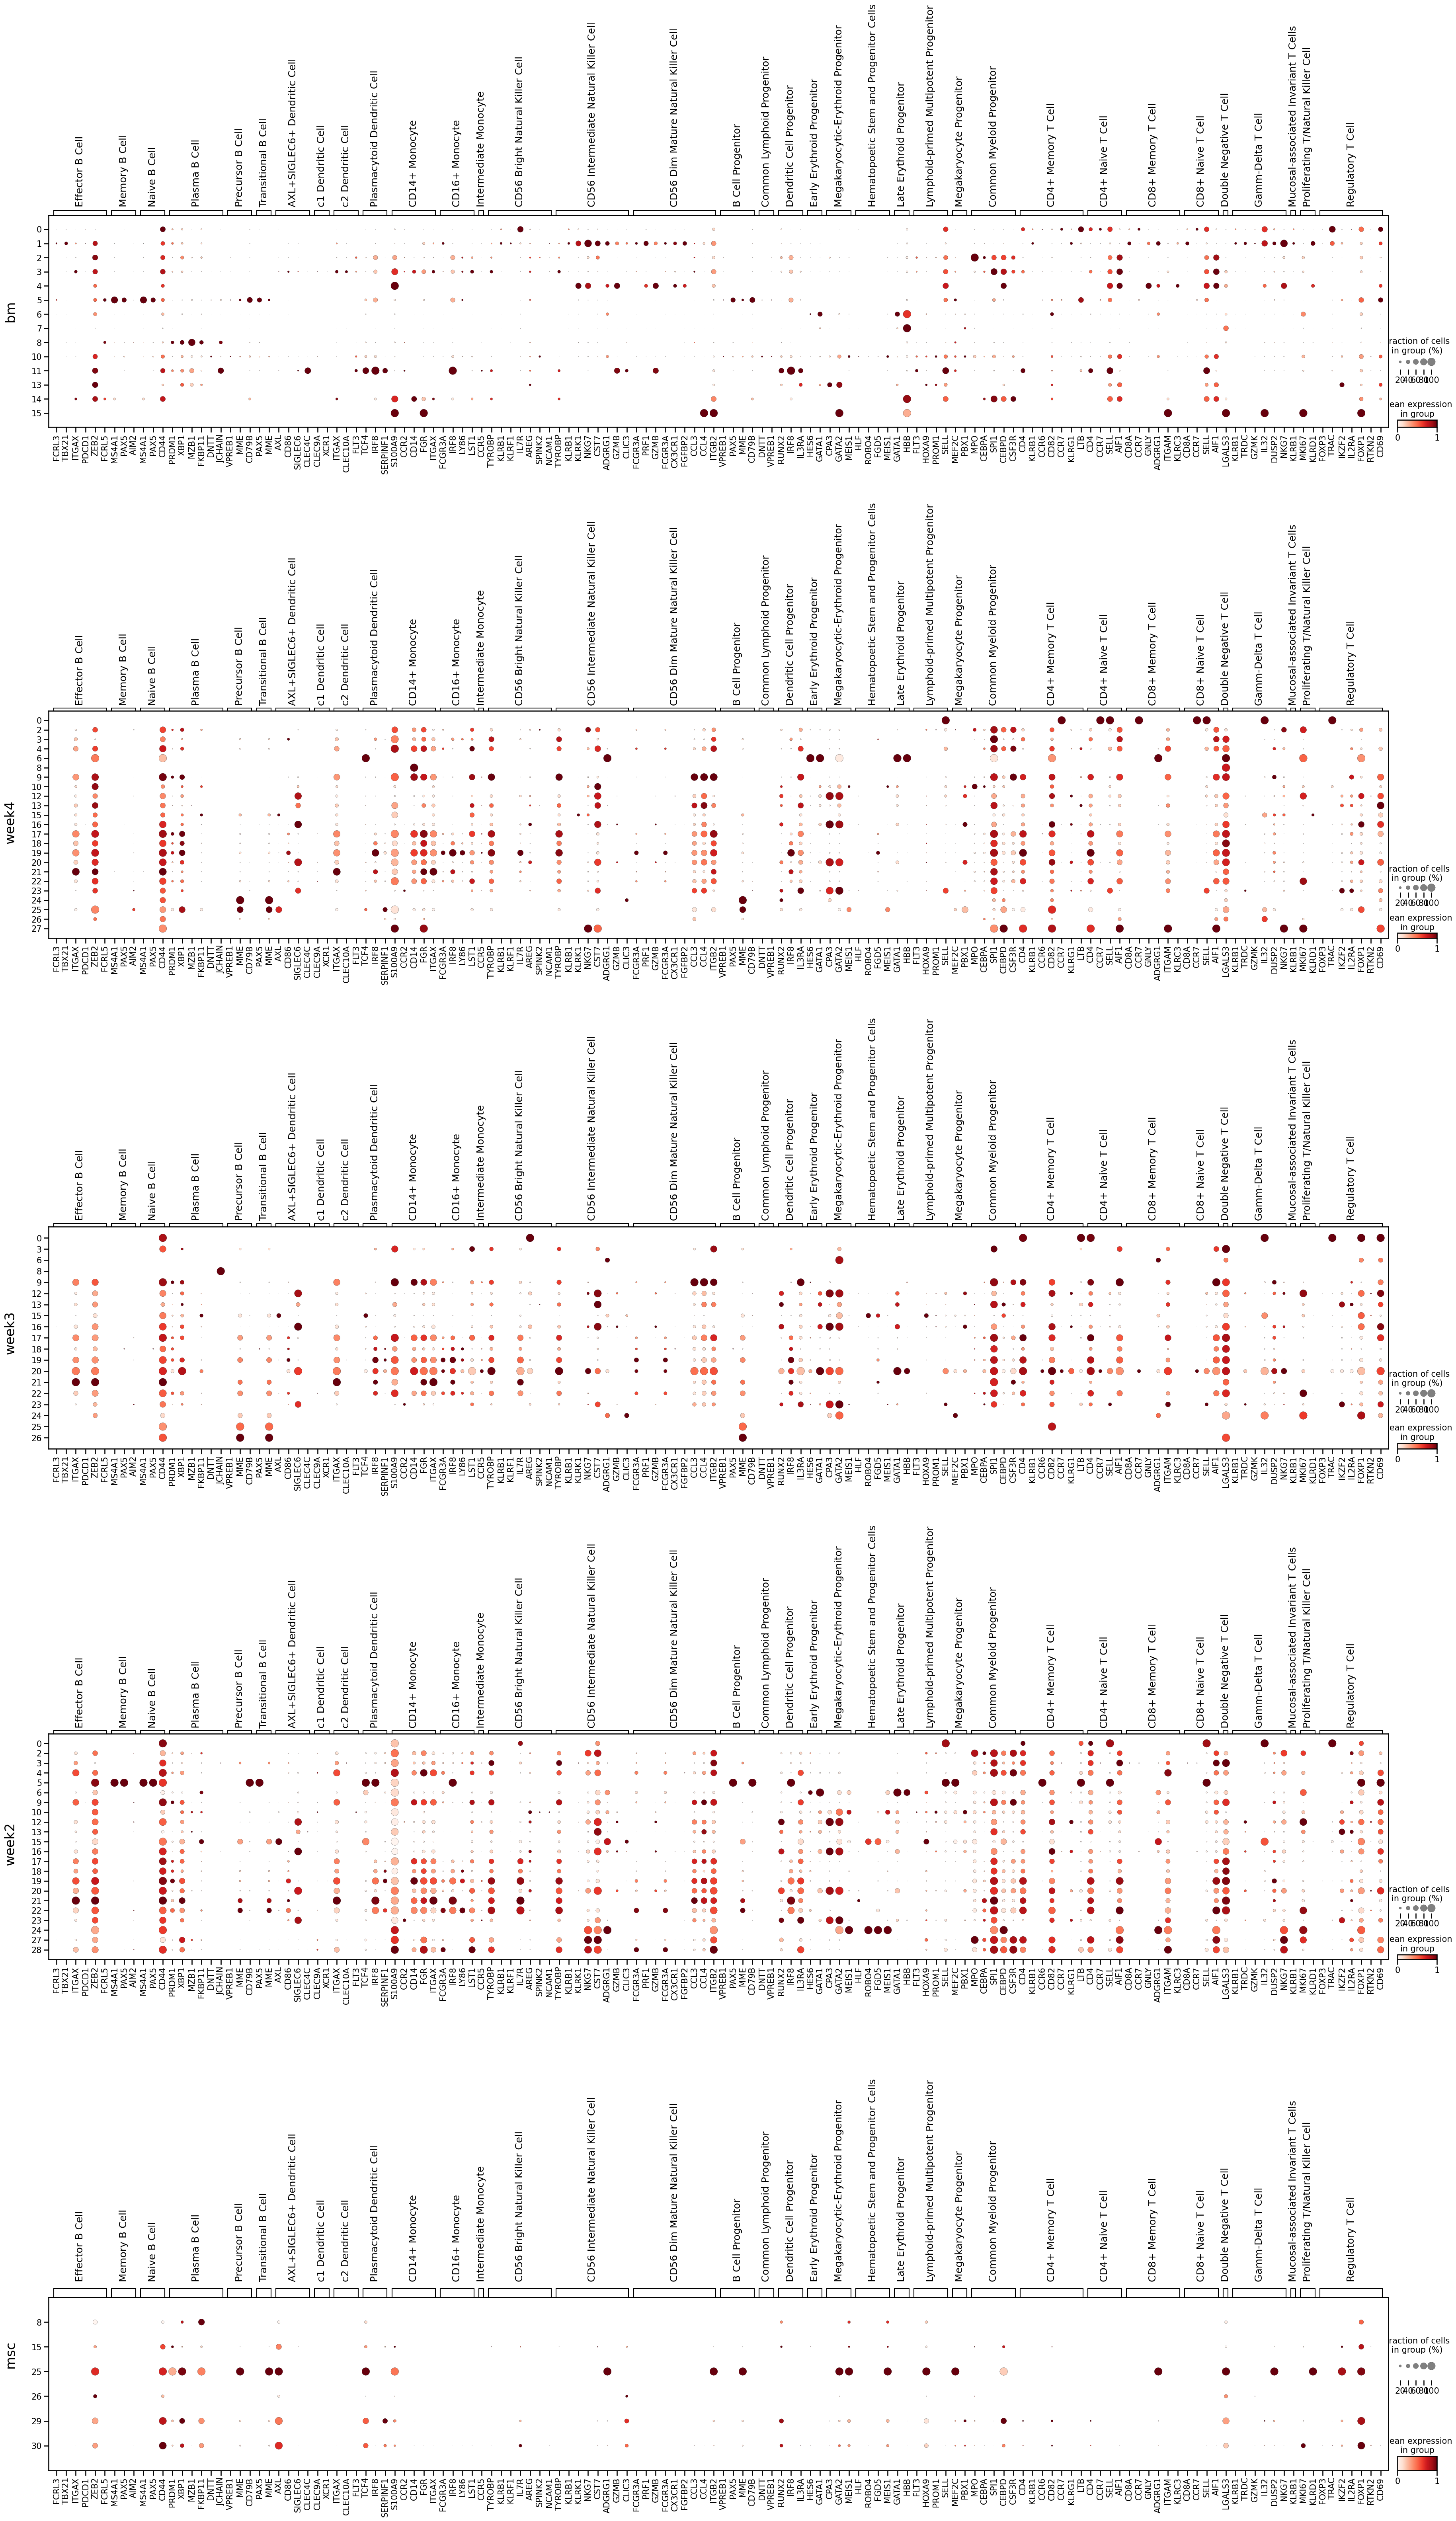

In [67]:
adatas = {
    name: adata[adata.obs['sample_type'] == name].copy()
    for name in adata.obs['sample_type'].unique()
}

fig, ax = plt.subplots(len(adatas), figsize=(45, 15*len(adatas)), gridspec_kw={"hspace": 1})

for i, (name, data) in enumerate(adatas.items()):
    sc.pl.dotplot(
        data,
        marker_genes,
        groupby="leiden",
        standard_scale="var",
        show=False,
        ax=ax[i]
        # figsize=(40, 30)
    )

    bbox = ax[i].get_position()
    y_center = bbox.y0 + bbox.height/2.2
    
    fig.text(0.1, y_center, name, rotation=90, va='center', fontsize=24)